# Cis Effects Template

NOTE: This notebook only looks at cis-effects for events on a single arm. If you're looking at different arm-level events on both arms of a chromosome, then make one copy of this template for the p arm, and another copy for the q arm.

This notebook compares the transcriptomics and proteomics correlations to CNV for cis proteins.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from cnvutils import *
import statsmodels.stats.multitest
import cptac.utils

In [2]:
# These variables specify which chromosome and arm we're working on, and whether to do cis or trans effects
CHROMOSOME = '8'
ARM = 'p'
CIS_OR_TRANS = "cis"

# Fill in the values below, according to which arm and event you're looking at

if ARM == "p":
    EVENT_COLUMN = "loss_event"
    EXCLUDE_COLUMN = "gain_event"
    EVENT_START = 0
    EVENT_END = 30794385
    
elif ARM == "q":
    EVENT_COLUMN = "gain_event"
    EXCLUDE_COLUMN = "loss_event"
    EVENT_START = 80794385
    EVENT_END = 130794385

else:
    raise ValueError("Invalid value for ARM variable.")

In [3]:
cancer_types = {
    # Put here all the types of cancer that you want to look at. 
    'brca': cptac.Brca,
#     'ccrcc': cptac.Ccrcc,
    'colon': cptac.Colon,
#     'endometrial': cptac.Endometrial,
#     'gbm': cptac.Gbm,
    'hnscc': cptac.Hnscc,
    'luad': cptac.Luad,
    'lscc': cptac.Lscc,
    'ovarian': cptac.Ovarian,
}

## Load all the data

In [4]:
proteomics = dict()
cnv = dict()
transcriptomics = dict()

for cancer_type in cancer_types:
    
    dataset = cancer_types[cancer_type]()
    
    proteomics[cancer_type] = dataset.get_proteomics()
    cnv[cancer_type] = dataset.get_CNV()
    transcriptomics[cancer_type] = dataset.get_transcriptomics()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


In [5]:
# Get just the genes that are in our event
genes = get_event_genes(
    chrm=CHROMOSOME,
    event_start=EVENT_START,
    event_end=EVENT_END,
    cis_or_trans=CIS_OR_TRANS
)["Name"].\
drop_duplicates(keep="first")

## Run Pearson Tests

In [6]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [7]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [8]:
proteomics_results

,brca_pvalue_proteomics,brca_rvalue_proteomics,colon_pvalue_proteomics,colon_rvalue_proteomics,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,luad_pvalue_proteomics,luad_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics
Name,,,,,,,,,,,,
ADAM28,NaN,NaN,NaN,NaN,2.101203e-01,0.177958,1.258166e-01,0.181190,1.484537e-03,0.384724,8.092260e-01,0.096571
ADAMDEC1,6.599418e-01,0.055638,3.905185e-01,0.112317,8.229400e-01,0.043884,4.036049e-01,0.147031,8.816820e-01,0.018812,9.001397e-01,0.034902
AGPAT5,8.098194e-07,0.457864,1.510768e-05,0.458805,7.994840e-07,0.487085,1.352256e-05,0.427622,7.074012e-07,0.485135,1.128429e-06,0.554238
ANGPT2,3.429629e-01,-0.115367,NaN,NaN,2.243537e-01,-0.171935,5.558500e-01,0.060401,5.128528e-01,-0.070234,9.933934e-02,0.375279
ARHGEF10,1.506012e-05,0.404322,6.870607e-02,0.338850,3.850612e-05,0.413378,1.439027e-05,0.425873,9.217985e-03,0.268300,3.167806e-05,0.483415
ASAH1,3.218373e-01,0.110194,9.874628e-04,0.359209,4.654972e-02,0.222722,1.955759e-02,0.240366,2.908597e-01,0.117033,4.614506e-05,0.474588
ATP6V1B2,5.204870e-07,0.466969,1.633914e-10,0.620143,1.026216e-04,0.393477,2.685797e-05,0.413558,2.342095e-09,0.563342,4.184923e-06,0.526577
BIN3,2.563241e-01,0.123832,1.102297e-01,0.192149,1.772803e-01,0.156110,1.191888e-02,0.258241,3.577023e-01,0.102610,2.801025e-04,0.430885
BLK,1.367744e-01,-0.156130,NaN,NaN,3.853766e-01,-0.202301,2.125565e-02,0.259306,NaN,NaN,8.057943e-01,-0.052979


### Transcriptomics

In [9]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/s

In [10]:
transcriptomics_results

,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,colon_pvalue_transcriptomics,colon_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,lscc_pvalue_transcriptomics,lscc_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics
Name,,,,,,,,,,,,
ADAM28,5.894005e-01,0.066001,1.428113e-03,0.315575,2.376143e-03,0.316978,6.692753e-05,0.385313,1.224181e-06,0.462003,9.126783e-03,0.280817
ADAM7,9.660800e-01,-0.028535,NaN,NaN,1.222645e-02,0.266969,2.741089e-01,0.155861,NaN,NaN,4.192196e-01,0.090221
ADAMDEC1,9.476551e-01,-0.009901,4.422239e-01,0.080675,5.304478e-01,-0.076315,1.835600e-01,0.133510,1.022032e-03,0.324688,3.985419e-01,-0.094751
ADRA1A,4.267885e-01,-0.117523,NaN,NaN,7.769012e-02,0.197855,5.671480e-02,0.193623,1.910673e-02,0.241025,8.324881e-01,-0.023195
AGPAT5,7.515479e-11,0.570129,4.838641e-15,0.681015,8.950410e-09,0.541940,1.163703e-09,0.555235,3.396703e-07,0.482015,1.756809e-10,0.605721
ANGPT2,2.394621e-01,0.136556,1.278675e-01,0.157427,1.136525e-01,0.180657,6.185632e-04,0.335415,2.681918e-01,0.112071,3.544853e-01,0.105211
ARHGEF10,1.285361e-08,0.509890,1.639074e-03,0.311672,9.357745e-04,0.341570,1.928710e-06,0.451284,7.409591e-05,0.386414,1.036175e-05,0.445733
ASAH1,1.032829e-02,0.255238,9.026101e-11,0.588519,1.808026e-06,0.465118,1.916578e-06,0.451644,8.048219e-11,0.589132,4.626535e-13,0.666710
ATP6V1B2,1.921483e-07,0.472570,2.475710e-18,0.735707,7.750239e-13,0.641970,3.095645e-06,0.443411,9.849153e-17,0.706147,1.793186e-10,0.604863


## Create Graphs

In [11]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

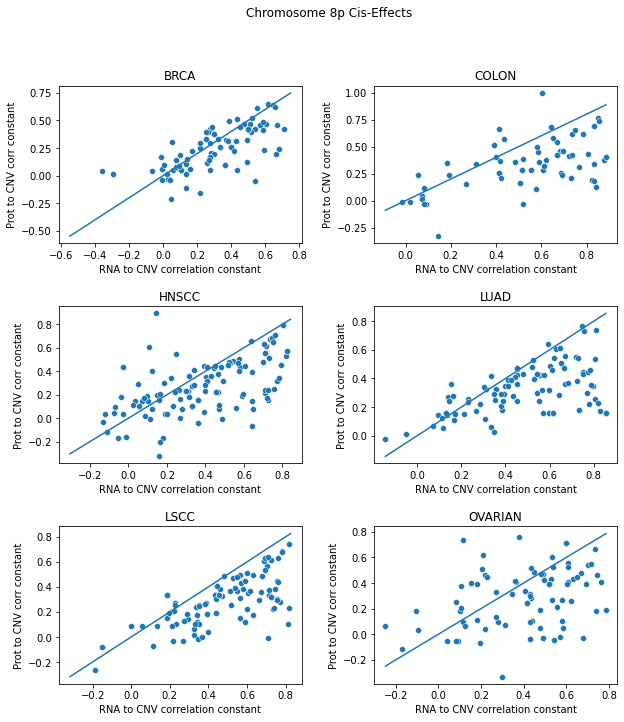

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("RNA to CNV correlation constant")
    axs[count//2][count%2].set_ylabel("Prot to CNV corr constant")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)